In [2]:
import pandas as pd
import math
from time import gmtime, strftime
import seaborn as sns
from sklearn.externals import joblib
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm_notebook
from sklearn import metrics
from sklearn import model_selection
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import feature_selection
from sklearn import cluster
from sklearn import gaussian_process
from sklearn import neighbors
from sklearn import neural_network
from sklearn import isotonic
from sklearn import tree
from sklearn import svm
from collections import Counter
from scipy import stats
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import GaussianDropout
from keras import optimizers
from keras import initializers
from keras import regularizers
from keras import backend as K
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 400

In [3]:
def output_to_file(id_series, pred_data_without_exp):
    pred_data_without_exp = np.expm1(pred_data_without_exp)
    final_result = pd.concat([id_series, pd.DataFrame({'SalePrice':pred_data_without_exp}, index=id_series.index)], axis=1)
    print(final_result)
    final_result.to_csv('prediction_{}.csv'.format(strftime("%Y_%m_%d_%H_%M_%S")), index=False)

In [4]:
def save(obj, name):
    try:
        joblib.dump(obj, name)
    except:
        print('Save Failed')

# Raw Data

In [5]:
train_data_url = 'train.csv'
test_data_url = 'test.csv'
raw_train_data = pd.read_csv(train_data_url)
raw_test_data = pd.read_csv(test_data_url)
all_features = pd.concat([raw_train_data.drop(columns=["SalePrice"]), raw_test_data], axis=0)

# Validation Framework

In [6]:
def rmse(y, y_pred):
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

def rmse_keras(y, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y))) 

rmse_scorer = metrics.make_scorer(lambda y,y_pred:np.sqrt(metrics.mean_squared_error(y,y_pred)), greater_is_better=False)

def cross_validate(
    models, 
    features,
    labels,
    outlier_remove_method=None,
    k_fold=3,
    holdout_rate=0.1,
    n_epochs=1,
    loss=rmse,
    tolerate_span=0.03,
    verbose=1,
    ylim=(0,1)
):
    
    assert len(features) == len(labels), 'features and labels should have same number of rows'
    if type(models) is not list:
        models = [models]
           
    if type(features) is not pd.DataFrame:
        features = pd.DataFrame(features)

    if type(labels) is not pd.Series and type(labels) is not pd.DataFrame:
        labels = pd.Series(labels)
        
    if isinstance(n_epochs, (int, float, np.int32, np.int64, np.float32, np.float64)):
        n_epochs = [int(n_epochs)] * len(models)
        
    info = {}
        
    kfold = model_selection.KFold(n_splits=k_fold)
    n_holdout = int(len(features) * holdout_rate)
    variance_dict = {}
    cv_pred_all_models = None
    qualified_models = []
    if outlier_remove_method is not None and outlier_remove_method.__class__.__name__ == 'IsolationForest':
        outlier_remove_method.fit(features, labels)
    
    for model_idx, model in enumerate(tqdm_notebook(models)):
        variance_dict[model_idx] = []
        
        random_idx = np.random.permutation(features.index)
        features = features.reindex(random_idx)
        labels = labels.reindex(random_idx)
        holdout_features, holdout_labels = features[:n_holdout], labels[:n_holdout]
        remain_features, remain_labels = features[n_holdout:], labels[n_holdout:]
        
        if outlier_remove_method is not None and outlier_remove_method.__class__.__name__ == 'IsolationForest':
            group_idx = outlier_remove_method.predict(remain_features.values)
            cur_features = remain_features.iloc[[idx != -1 for idx in group_idx]]
            cur_labels = remain_labels.iloc[[idx != -1 for idx in group_idx]]
        else:
            cur_features = remain_features
            cur_labels = remain_labels
        
        for e in range(n_epochs[model_idx]):
            i = 0
            cv_pred = None
            for train_idx, val_idx in kfold.split(cur_features, cur_labels):
                i += 1
                
                cur_fold_features = cur_features.iloc[train_idx]
                cur_fold_labels = cur_labels.iloc[train_idx]
                
                
                if len(cur_features) == 0:
                    return None, None, {}
                
                if model.__class__.__name__ == 'Sequential':
                    model.fit(cur_fold_features.values, cur_fold_labels.values.reshape(-1,))
                elif model.__class__.__name__ == 'CatBoostRegressor':
                    model.fit(cur_fold_features.values, cur_fold_labels.values.reshape(-1,), verbose=False)
                else:
                    model.fit(cur_fold_features.values, cur_fold_labels.values.reshape(-1,))
                    
                pred = model.predict(cur_features.iloc[val_idx].values)

                if cv_pred is None:
                    cv_pred = pred.reshape((-1, 1))
                    cv_label = cur_labels.iloc[val_idx]
                else:
                    cv_pred = np.concatenate((cv_pred, pred.reshape((-1, 1))), axis=0)
                    cv_label = pd.concat([cv_label, remain_labels.iloc[val_idx]], axis=0)

                variance = loss(cur_labels.iloc[val_idx], pred)
                variance_dict[model_idx].append(variance)

                if verbose > 1:
                    print("Ep{}|{} ({}/{}) validation {}: {}".format(e, model.__class__.__name__, i, k_fold, loss.__name__, variance))
        
        cv_variance = loss(cv_label, cv_pred)
        train_pred_loss = loss(remain_labels, model.predict(remain_features.values))
        
        if verbose > 0:
            print("{} Train data average {}: {}".format(model.__class__.__name__, loss.__name__, train_pred_loss))
            
        if holdout_rate > 0:
            cv_pred_with_holdout = np.concatenate((model.predict(holdout_features.values).reshape((-1, 1)), cv_pred), axis=0)
        else:
            cv_pred_with_holdout = cv_pred
            
        if cv_pred_all_models is None:
            cv_pred_all_models = cv_pred_with_holdout
        else:
            if cv_pred_all_models.shape[0] == cv_pred_with_holdout.shape[0]:
                cv_pred_all_models = np.concatenate((cv_pred_all_models, cv_pred_with_holdout), axis=1)
            else:
                if type(cv_pred_all_models) != list:
                    cv_pred_all_models = [cv_pred_all_models]
                cv_pred_all_models.append(cv_pred_with_holdout)
                
        info[model_idx] = {'cv': cv_variance}
        info[model_idx]['train'] = train_pred_loss
        
        if model.__class__.__name__ == 'Sequential':
            model.fit(remain_features.values, remain_labels.values.reshape(-1,))
        elif model.__class__.__name__ == 'CatBoostRegressor':
            model.fit(remain_features.values, remain_labels.values.reshape(-1,), verbose=False)
        else:
            model.fit(remain_features.values, remain_labels.values.reshape(-1,))
            
        if holdout_rate > 0:
            holdout_variance = loss(holdout_labels, model.predict(holdout_features.values))
            info[model_idx]['holdout'] = holdout_variance
            
            if verbose > 0:
                print("{} Holdout {}: {}".format(model.__class__.__name__, loss.__name__, holdout_variance))

            if holdout_variance - tolerate_span <= cv_variance:
                qualified_models.append(model)
        else:
            qualified_models.append(model)

    if verbose >= 2:
        plt.gca().set_ylim(*ylim)
        for i, variance_list in enumerate(variance_dict.values()):
            plt.plot(variance_list, label=models[i].__class__.__name__)
        plt.legend()
        plt.show()
        
    return qualified_models, cv_pred_all_models, info
    

## Prediction Distribution

In [7]:
def show_dist(models, features, labels, on_one_plot=False):
    if type(features) != np.ndarray:
        features = features.values
    model_preds = [model.predict(features).reshape((-1, 1)) for model in models]
    if on_one_plot:
        plt.figure(figsize=(12, 4))
        sns.distplot(labels, hist=False, label='Labels')
        for i, pred in enumerate(model_preds):
            sns.distplot(pred, hist=False, label=models[i].__class__.__name__)
            plt.legend()
            
    else:
        plt.figure(figsize=(12, 4*len(models)))
        for i, pred in enumerate(model_preds):
            plt.subplot(len(models), 1, i+1)
            sns.distplot(pred, hist=False, label=models[i].__class__.__name__)
            sns.distplot(np.log1p(raw_train_data['SalePrice']), hist=False, label='Labels')
            plt.legend()
            
    plt.show()
            
def show_diff(models, features, labels, on_one_plot=False):
    if type(labels) is pd.DataFrame or type(labels) is pd.Series:
        labels = labels.values
    if type(features) != np.ndarray:
        features = features.values
    model_preds = [model.predict(features).reshape((-1, 1)) for model in models]
    if on_one_plot:
        plt.figure(figsize=(12, 4))
        plt.plot(labels, label='Labels')
        for i, pred in enumerate(model_preds):
            plt.plot(pred, label=models[i].__class__.__name__)
            plt.legend()
    else:
        plt.figure(figsize=(12, 4*len(models)))
        for i, pred in enumerate(model_preds):
            plt.subplot(len(models), 1, i+1)
            plt.plot(pred, label=models[i].__class__.__name__)
            plt.plot(labels, label='Labels')
            plt.legend()
            
    plt.show()
    
def show_pred_diff(labels, pred_labels):
    if isinstance(labels, (pd.DataFrame, pd.Series)):
        labels = labels.copy().values.reshape(-1,)
    if isinstance(pred_labels, (pd.DataFrame, pd.Series)):
        pred_labels = pred_labels.copy().values.reshape(-1,)

    sort_idx = np.argsort(labels)
    labels.sort()
    pred_labels = pred_labels[sort_idx]
    plt.figure(figsize=(12, 4))
    plt.plot(labels, label='y')
    plt.plot(pred_labels, label='y_pred')
    plt.legend()
    plt.show()

# Final validation framework

In [50]:
def validation_framework(
    models_1,
    features,
    labels,
    loss_fn,
    outlier_remove_method=None,
    models_2=None,
    k_fold_1=10,
    k_fold_2=3,
    holdout_rate=0.1,
    tolerate_span=0.1,
    ylim=(0, 0.5),
    n_epochs_1=1,
    n_epochs_2=1,
    shuffle=True,
    verbose=1
):

    features = pd.DataFrame(features, copy=True)
    if type(labels) is pd.DataFrame:
        labels = pd.DataFrame(labels, copy=True)
    else:
        labels = pd.Series(labels, copy=True)
    
    if verbose > 0:
        print("Stage 1 - Without Holdout:")
    
    if shuffle:
        perm_index = np.random.permutation(features.index)
        features = features.reindex(perm_index)
        labels = labels.reindex(perm_index)
   
    models_1, cv_pred_1_without_holdout, info_1_without_holdout = cross_validate(
        models_1, 
        features,
        labels,
        outlier_remove_method=outlier_remove_method,
        loss=loss_fn,
        k_fold=k_fold_1,
        tolerate_span=tolerate_span,
        verbose=verbose,
        ylim=ylim,
        n_epochs=n_epochs_1
    )
    
    if models_1 is None:
        return [None], None, {}
    
    if models_2 is not None:
        models_2, _, info_2_without_holdout = cross_validate(
            models_2, 
            cv_pred_1_without_holdout,
            labels,
            loss=loss_fn,
            k_fold=k_fold_1,
            tolerate_span=tolerate_span,
            verbose=verbose,
            ylim=ylim,
            n_epochs=n_epochs_2
        )
        
        if models_2 is None:
            return [None], None, {}
    
    if verbose > 0:
        print("\nStage 2 - With Holdout:")
    
    if shuffle:
        perm_index = np.random.permutation(features.index)
        features = features.reindex(perm_index)
        labels = labels.reindex(perm_index)

    models_1, cv_pred_with_holdout, info_1_with_holdout = cross_validate(
        models_1,
        features,
        labels,
        outlier_remove_method=outlier_remove_method,
        holdout_rate=0,
        loss=loss_fn,
        k_fold=k_fold_2,
        tolerate_span=tolerate_span,
        verbose=verbose,
        ylim=ylim,
        n_epochs=n_epochs_1
    )
    
    if models_1 is None:
        return [None], None, {}
    
    if models_2 is not None:
        models_2, _, info_2_with_holdout = cross_validate(
            models_2, 
            cv_pred_with_holdout,
            labels,
            holdout_rate=0,
            loss=loss_fn,
            k_fold=k_fold_2,
            tolerate_span=tolerate_span,
            verbose=verbose,
            ylim=ylim,
            n_epochs=n_epochs_2
        )
        
        if models_2 is None:
            return [None], None, {}
    
    if verbose > 0:
        show_dist(models_1, features, labels, on_one_plot=True if verbose == 1 else False)
        if models_2 is not None:
            show_dist(models_2, cv_pred_with_holdout, labels, on_one_plot=True if verbose == 1 else False)
        
        if type(labels) is pd.DataFrame:
            sorted_index = labels.sort_values(by="SalePrice").index
        else:
            sorted_index = labels.sort_values().index
            
        sorted_features = features.reindex(sorted_index)
        sorted_labels = labels.reindex(sorted_index)
#         sorted_cv_pred_with_holdout = pd.DataFrame(data=cv_pred_with_holdout, index=features.index)
#         sorted_cv_pred_with_holdout = sorted_cv_pred_with_holdout.reindex(sorted_index)
        
        show_diff(models_1, sorted_features, sorted_labels.values, on_one_plot=True if verbose == 1 else False)
#         if models_2 is not None:
#             show_diff(models_2, sorted_cv_pred_with_holdout, sorted_labels.values, on_one_plot=True if verbose == 1 else False)
    
    if models_2 is not None:
        info = {"m1wo":info_1_without_holdout, "m2wo":info_2_without_holdout,
                "m1":info_1_with_holdout, "m2":info_2_with_holdout}
    else:
        info = {"m1wo":info_1_without_holdout, "m1":info_1_with_holdout}
        
    return models_1, models_2, info

# Naive data processing 

In [9]:
def naive_data_process(features, labels):
    new_features = pd.DataFrame(features, copy=True)
    new_labels = np.log1p(pd.DataFrame(labels, copy=True))
    for col_name in list(new_features):
        if new_features[col_name].dtypes == np.object:
            new_features[col_name] = new_features[col_name].fillna('NA')
        else:
            new_features[col_name] = new_features[col_name].fillna(new_features[col_name].mean())

    new_features = pd.get_dummies(new_features)
    
    return new_features, new_labels

train_features, train_labels = naive_data_process(raw_train_data.drop(columns=["SalePrice"]), raw_train_data["SalePrice"])

# Explore the Data

## Data Testing Tools

In [10]:
def data_test_run(features, labels, outlier_method=None, verbose=3):
    test_model1 = linear_model.Ridge()
    test_model2 = ensemble.GradientBoostingRegressor()
    test_model3 = ensemble.RandomForestRegressor()
    test_model4 = XGBRegressor()
    test_model5 = LGBMRegressor()
    test_models = [test_model1, test_model2, test_model3, test_model4, test_model5]
    
    _, _, info = validation_framework(
        models_1=test_models,
        models_2=None,
        features=features,
        labels=labels,
        loss_fn=rmse,
        outlier_remove_method=outlier_method,
        k_fold_1=10,
        k_fold_2=10,
        holdout_rate=0.17,
        tolerate_span=0.1,
        ylim=(0, 0.5),
        n_epochs_1=1,
        n_epochs_2=1,
        verbose=verbose
    )
    return info

def data_test_summary(features, labels, times=10, outlier_method=None, verbose=3):
    assert times >= 1, 'Times must be larger than 0'
    info = data_test_run(features, labels, outlier_method, verbose)
    info_df = pd.DataFrame(info['m1wo'])
    
    for _ in range(times - 1):
        info = data_test_run(features, labels, outlier_method, verbose)
        info_df = info_df + pd.DataFrame(info['m1wo'])
        
    info_df = info_df / times
    return info_df
    

## Fill missing data by hand

- MiscFeature should be NA if missing
- PoolQC should be NA, if no pool existed. Fence is the same. √
- If GarageCars is 0, then GarageType, GarageFinish, GarageQual, GarageCond, shoule be NA √
- If Fireplaces is 0, then FireplaceQu should be NA  √
- If KitchenAbvGr is 0, then KitchenQual should be NA  √
- BsmtFullBath, BsmtHalfBath should be 0, if BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 is NA  √
- if BsmtFinSF1 BsmtFinSF2 is 0, BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 should be NA  √
- MasVnrArea should be 0, if MasVnrType is None and vice versa.  √
- Exterior1st Exterior2nd should be Oth
- Utilities shoule be NA, if missing
- Alley should be set NA?
- if Alley is NA, then LotFrontage should be 0

# Mature data processing

In [11]:
def mature_data_process(features, labels=None, fn_list=[]):
    new_features = pd.DataFrame(features, copy=True)
    new_labels = pd.DataFrame(labels, copy=True)
    for fn in fn_list:
        new_features, new_labels = fn(new_features, features, new_labels)
    
    if labels is not None:
        new_labels = np.log1p(new_labels)
        return new_features, new_labels
    
    return new_features

In [12]:
def fill_na_by_hand(features, *args):
    features.loc[features['MiscFeature'].isnull(),'MiscFeature'] = 'NA'
    features.loc[features['PoolArea']==0,'PoolQC'] = 'NA'
    features.loc[features['Fence'].isnull(),'Fence'] = 'NA'
    features.loc[features['GarageCars']==0, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = 'NA'
    features.loc[features['Fireplaces']==0, 'FireplaceQu'] = 'NA'
    features.loc[features['KitchenAbvGr']==0, 'KitchenQual'] = 'NA'
    features.loc[
        (features.loc[:,['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]=='NA').sum(axis=1)>0,
        ['BsmtFullBath', 'BsmtHalfBath']
    ] = 0
    features.loc[
        (features.loc[:,['BsmtFinSF1', 'BsmtFinSF2']]==0).sum(axis=1)>0,
        ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    ] = 'NA'
    features.loc[features['MasVnrType']=='None', 'MasVnrArea'] = 0
    features.loc[features['MasVnrArea']==0, 'MasVnrType'] = 'None'
    features.loc[features['Exterior1st'].isnull(), 'Exterior1st'] = 'Oth'
    features.loc[features['Exterior2nd'].isnull(), 'Exterior2nd'] = 'Oth'
    features.loc[features['Utilities'].isnull(), 'Utilities'] = 'NA'
    features.loc[features['Alley'].isnull(), 'Alley'] = 'NA'
    features.loc[features['Alley']=='NA', 'LotFrontage'] = 0
    return features, args[1]

def drop_na_features(features, *args):
    drop_col = []
    for col_name in list(features):
        missing_count = features[col_name].isnull().sum()
        percentage = missing_count / len(features[col_name])
        if percentage > 0.6 or missing_count > 1000:
            drop_col.append(col_name)
        elif percentage > 0:
            if features[col_name].dtypes == np.object:
                features[col_name] = features[col_name].fillna('NA')
                if col_name == 'MasVnrArea':
                    features.loc[features[col_name]=='None', col_name] = 'NA'
            else:
                features[col_name] = features[col_name].fillna(features[col_name].mean())
    features.drop(columns=drop_col, inplace=True, errors='ignore')
    return features, args[1]

def fill_numeric(features, *args):
    for col_name in features.select_dtypes(exclude=['object']).columns.tolist():
        features[col_name] = features[col_name].fillna(features[col_name].mean())
    return features, args[1]

def rectify_skewness(features, *args):
    quality_cols = {'GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond'}
    quality_cols = quality_cols
    for col_name in features.select_dtypes(exclude=['object']).columns.tolist():
        if col_name not in quality_cols and features[col_name].skew() > 0.7:
            features[col_name] = np.log1p(features[col_name])
    return features, args[1]
    
def custom_drop(features, *args):
    drop_set = {'MasVnrArea', 'KitchenAbvGr', 'MiscVal', 'YrSold', '3SsnPorch', 'BsmtHalfBath', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath'}
    features.drop(columns=list(drop_set), inplace=True, errors='ignore')
    return features, args[1]

def indicate_quality(features, *args):
    qualities = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
    mapping = {qual:score for qual, score in zip(qualities, [*range(0, 6)])}
    mapping[np.nan] = 0
    quality_cols = {'GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond'}
    quality_cols = quality_cols & set(features.columns.tolist())
    for col_name in quality_cols:
        features[col_name] = features[col_name].apply(lambda x:mapping[x])
        
    features['CentralAir'] = features['CentralAir'].map({'Y':1, 'N':0})
    return features, args[1]

def custom_cat_drop(features, *args):
    categorical_drop = {'Condition2', 'RoofStyle','Electrical', 'Functional'}
    features.drop(columns=categorical_drop, inplace=True, errors='ignore')
    return features, args[1]

def modify_year(features, *args):
    year_cols = {'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'}
    for col_name in year_cols:
        features[col_name] = 2018 - features[col_name]
    return features, args[1]

def add_YrRemodBeforeSold(features, *args):
    ori_features = args[0]
    features['YrRemodBeforeSold'] = ori_features['YrSold'] - ori_features['YearRemodAdd']
    return features, args[1]

def add_Season(features, *args):
    season_dict = {1:1, 2:1, 3:1, 4:0, 5:0, 6:0, 7:3, 8:3, 9:3, 10:2, 11:2, 12:2}
    features['SoldSeason'] = features['MoSold'].map(season_dict)
    return features, args[1]
    
def add_NewerDwelling(features, *args):
    ori_features = args[0]
    features["NewerDwelling"] = ori_features["MSSubClass"].replace(
    {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
     90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})
    return features, args[1]

def add_NrhdPriority(features, *args):
    ori_features = args[0]
    neighbor_bin_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }
    features['NrhdPriority'] = ori_features['Neighborhood'].map(neighbor_bin_map)
    return features, args[1]
    
def dummies(features, *args):
    features['MSSubClass'] = features['MSSubClass'].apply(lambda x:str(x))
    features['MoSold'] = features['MoSold'].apply(lambda x:str(x))
    features = pd.get_dummies(features)
    return features, args[1]

def drop_id(features, *args):
    features = features.drop(columns=["Id"])
    return features, args[1]

def scale(features, *args):
    features = pd.DataFrame(
        columns=features.columns,
        index=features.index,
        data=preprocessing.MinMaxScaler().fit_transform(features.values)
    )
    return features, args[1]

def denoising(features, *args):
    iso = ensemble.IsolationForest(n_estimators=200, contamination=0.01)
    iso.fit(features.values)
    group_idx = iso.predict(features.values)
    features = features.iloc[[idx != -1 for idx in group_idx]]
    labels = args[1]
    labels = labels.iloc[[idx != -1 for idx in group_idx[:len(labels)]]]
    return features, labels


In [13]:
fn_list = [drop_na_features, fill_numeric, rectify_skewness, custom_drop, indicate_quality, custom_cat_drop, dummies, drop_id, add_NewerDwelling, add_NrhdPriority, scale, denoising]#, modify_year, add_YrRemodBeforeSold, add_Season, , , 


Since only one version of data is necessary, I will make the best dataset as only

In [14]:
raw_features = raw_train_data.drop(columns=['SalePrice'])
raw_labels = raw_train_data['SalePrice']

features, labels = mature_data_process(raw_features, raw_labels, fn_list)

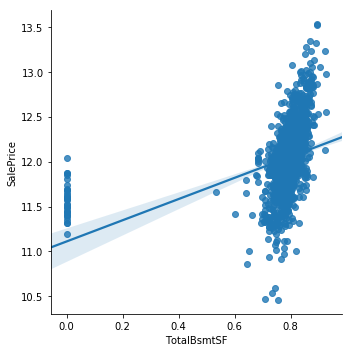

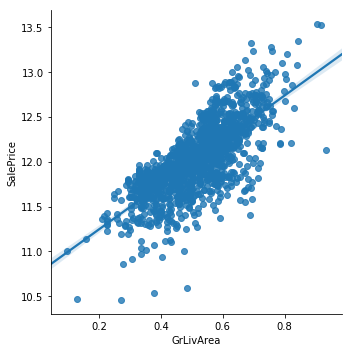

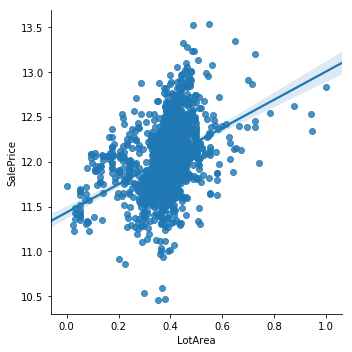

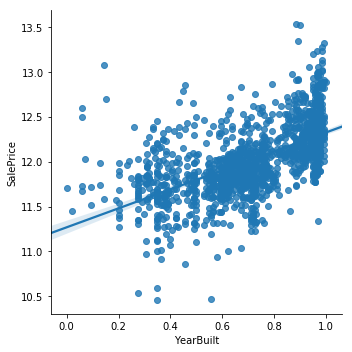

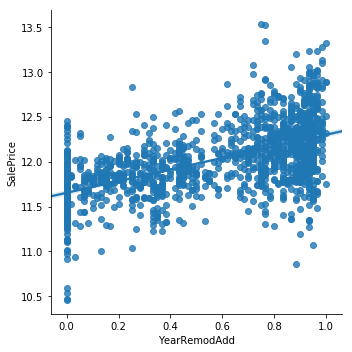

In [15]:
sns.lmplot('TotalBsmtSF', 'SalePrice', data=pd.concat([features, labels], axis=1))
sns.lmplot('GrLivArea', 'SalePrice', data=pd.concat([features, labels], axis=1))
sns.lmplot('LotArea', 'SalePrice', data=pd.concat([features, labels], axis=1))
sns.lmplot('YearBuilt', 'SalePrice', data=pd.concat([features, labels], axis=1))
sns.lmplot('YearRemodAdd', 'SalePrice', data=pd.concat([features, labels], axis=1))

## Validate the dataset

In [386]:
info_df = data_test_summary(features, labels, 10, outlier_method=None, verbose=0)

In [381]:
info_df

,0,1,2,3,4
cv,0.427666,0.413608,0.431132,0.409180,0.433394
holdout,0.119614,0.126920,0.147005,0.132527,0.129607
train,0.396602,0.405555,0.456593,0.394823,0.470613


# Find important features

In [16]:
def important_features(models, features, labels, verbose=0):
    if len(features) > len(labels):
        features = features[:len(labels)]
        
    if type(models) is not list:
        models = [models]
    
    info_df = None
    
    for model in models:
        [model], _, _ = validation_framework(
            [model],
            features=features,
            labels=labels,
            loss_fn=rmse,
            models_2=None,
            k_fold_1=10,
            k_fold_2=10,
            holdout_rate=0.1,
            tolerate_span=0.1,
            ylim=(0, 0.5),
            n_epochs_1=1,
            n_epochs_2=1,
            verbose=verbose
        )
        
        importance = pd.DataFrame(
            data=model.feature_importances_,
            index=features.columns,
            columns=['weight_{}'.format(model.__class__.__name__)]
        ).sort_values(by='weight_{}'.format(model.__class__.__name__), ascending=False)
        
        importance['features_{}'.format(model.__class__.__name__)] = importance.index
        importance.index = [*range(len(importance))]
        if info_df is None:
            info_df = importance
        else:
            info_df = pd.concat([info_df, importance], axis=1)
            
    return info_df

In [422]:
models = [ensemble.RandomForestRegressor(), ensemble.GradientBoostingRegressor()]
info_df = important_features(models, features, labels)

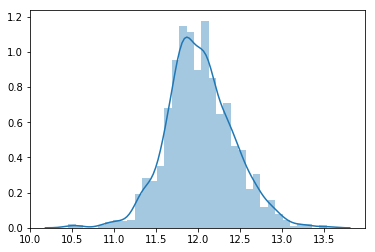

In [436]:
sns.distplot(labels)

# Neural Network

In [17]:
class NeuralNetwork:
    def __init__(self, learning_rate=0.0001, decay=1e-5, l1_reg=0, l2_reg=0, dropout=0.1, n_epochs=200, verbose=0, batch_size=1):
        self.lr = learning_rate
        self.decay = decay
        self.n_epochs = n_epochs
        self.model = Sequential()
        self.first_fit = True
        self.verbose = verbose
        self.batch_size = batch_size
        self.dropout = dropout
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def fit(self, features, labels):
        if self.first_fit:
            if isinstance(features, pd.DataFrame):
                features = features.values
            optimizer = optimizers.Adam(lr=self.lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=self.decay, amsgrad=False)
            self.model = Sequential() 
            self.l1 = Dense(units=128, 
                            input_dim=features.shape[1],
                            activation='tanh',
                            kernel_regularizer=regularizers.l1(self.l1_reg) if self.l1_reg > self.l2_reg else regularizers.l2(self.l2_reg))
            self.l2 = Dense(units=64,
                            activation='tanh',
                            kernel_regularizer=regularizers.l1(self.l1_reg) if self.l1_reg > self.l2_reg else regularizers.l2(self.l2_reg))
            self.l3 = Dense(units=1, activation='relu')
            self.model.add(GaussianDropout(self.dropout))
            self.model.add(self.l1)
            self.model.add(GaussianDropout(self.dropout))
            self.model.add(self.l2)
            self.model.add(self.l3)
            self.model.compile(loss='mean_squared_error', optimizer=optimizer)
            self.first_fit = False
            
        self.model.fit(features, labels, epochs=self.n_epochs, batch_size=self.batch_size, verbose=self.verbose)
        
    def predict(self, features):
        return self.model.predict(features)
    
    def get_params(self):
        return [self.l1, self.l2, self.l3]

# Tuning by hand

## Hypothesis:
1. If same model outperforms on one dataset than another dataset, we can assume this dataset is better than the other, which, I think, should be a unified rule

Stage 1 - Without Holdout:


Ep0|SVR (1/10) validation rmse: 0.1268227361772928
Ep0|SVR (2/10) validation rmse: 0.12409571676777881
Ep0|SVR (3/10) validation rmse: 0.10624573625183936
Ep0|SVR (4/10) validation rmse: 0.10883415673797381
Ep0|SVR (5/10) validation rmse: 0.12365881906550678
Ep0|SVR (6/10) validation rmse: 0.10602571693465247
Ep0|SVR (7/10) validation rmse: 0.13765650057090884
Ep0|SVR (8/10) validation rmse: 0.08199005869022158
Ep0|SVR (9/10) validation rmse: 0.12798059161400882
Ep0|SVR (10/10) validation rmse: 0.13152752341995316
SVR Train data average rmse: 0.11659522153189665
SVR Holdout rmse: 0.099619875359436


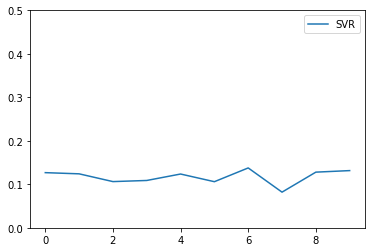


Stage 2 - With Holdout:


Ep0|SVR (1/3) validation rmse: 0.10817290946467183
Ep0|SVR (2/3) validation rmse: 0.12935980458717622
Ep0|SVR (3/3) validation rmse: 0.12007645358446169
SVR Train data average rmse: 0.11772248954143201


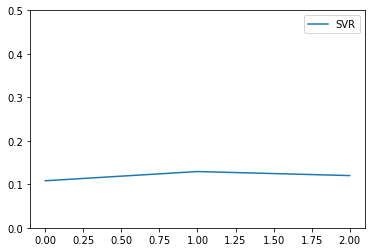

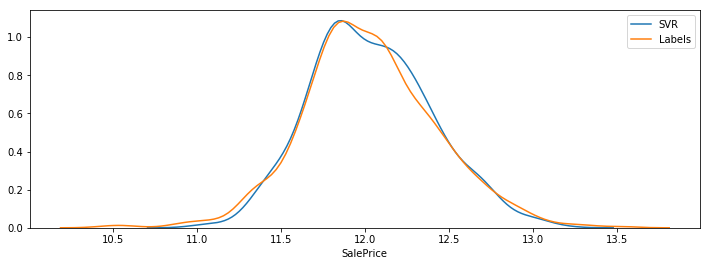

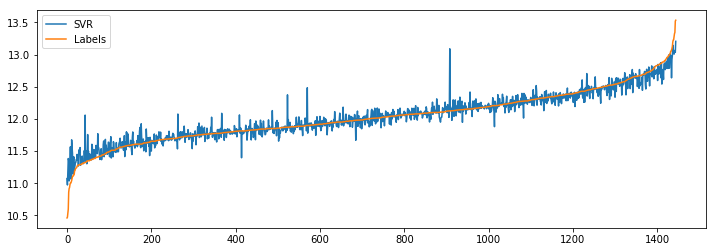

In [210]:
cur_model = svm.SVR(
    kernel='rbf', 
    #degree=2, 
    gamma=0.005,
    #coef0=0.01,
    tol=0.0001, 
    C=2.0, 
    epsilon=0.01, 
    shrinking=True,
    cache_size=200, 
    verbose=False,
    max_iter=-1)

cur_model, _, info = validation_framework(
    models_1=cur_model,
    features=features,
    labels=labels,
    loss_fn=rmse,
    outlier_remove_method=ensemble.IsolationForest(n_estimators=100, contamination=0.05),
    models_2=None,
    k_fold_1=10,
    k_fold_2=3,
    holdout_rate=0.2,
    tolerate_span=0.1,
    ylim=(0, 0.5),
    n_epochs_1=1,
    n_epochs_2=1,
    shuffle=False,
    verbose=2
)

In [211]:
save(cur_model, 'svr_holdout0.099')

# Conclusion


## Best parameter and coordinate dataset

ensemble.RandomForestRegressor(
    n_estimators=1000, 
    criterion='mse',
    min_samples_split=10,
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=0.3, 
    max_leaf_nodes=None,
    min_impurity_decrease=0.00001, 
    min_impurity_split=None, 
    bootstrap=True,
    oob_score=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0,
    warm_start=False
)

ensemble.GradientBoostingRegressor(
    loss='ls', 
    learning_rate=0.01,
    n_estimators=500, 
    subsample=0.5, 
    criterion='friedman_mse', 
    min_samples_split=15,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_depth=10, 
    min_impurity_decrease=0.0001,
    min_impurity_split=None, 
    init=None, 
    random_state=None, 
    max_features=0.1, 
    alpha=0.9, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    presort='auto')

XGBRegressor(
    max_depth=3, 
    learning_rate=0.1,
    n_estimators=500, 
    silent=True, 
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1, 
    nthread=None, 
    gamma=0.00001, 
    min_child_weight=1,
    max_delta_step=0, 
    subsample=1,
    colsample_bytree=0.6,
    colsample_bylevel=0.8, 
    reg_alpha=0.2,
    reg_lambda=0.2, 
    scale_pos_weight=1, 
    base_score=0.5, 
    random_state=0,
    seed=None, 
    missing=None)

LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.01,
    n_estimators=500, 
    max_bin=200,
    subsample_for_bin=50000,
    objective='regression', 
    min_split_gain=0.001, 
    min_child_weight=5, 
    min_child_samples=10, 
    subsample=0.8, 
    subsample_freq=1, 
    colsample_bytree=0.5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    seed=0, 
    nthread=-1,
    silent=True, 
    huber_delta=1.0,
    gaussian_eta=1.0,
    fair_c=1.0, 
    poisson_max_delta_step=0.7, 
    drop_rate=0.1,
    skip_drop=0.5, 
    max_drop=50, 
    uniform_drop=False, 
    xgboost_dart_mode=False)

~~CatBoostRegressor(iterations=1000, learning_rate=1, depth=2)~~

linear_model.BayesianRidge(
    n_iter=500, 
    tol=0.0001, 
    alpha_1=1e-04,
    alpha_2=1e-04, 
    lambda_1=1e-04,
    lambda_2=1e-04, 
    compute_score=True,
    fit_intercept=True, 
    normalize=True, 
    copy_X=True,
    verbose=False)

linear_model.ARDRegression(
    n_iter=300, 
    tol=0.001, 
    alpha_1=1e-05,
    alpha_2=1e-05, 
    lambda_1=1e-05,
    lambda_2=1e-05, 
    compute_score=False, 
    threshold_lambda=10000.0, 
    fit_intercept=True,
    normalize=False, 
    copy_X=True, 
    verbose=False)

linear_model.Ridge(
    alpha=1.0,
    fit_intercept=True,
    normalize=False, 
    copy_X=True, 
    max_iter=10000, 
    tol=0.0001, 
    solver='sparse_cg',
    random_state=None)

svm.SVR(
    kernel='rbf', 
    gamma=0.005,
    tol=0.0001, 
    C=2.0, 
    epsilon=0.01, 
    shrinking=True,
    cache_size=200, 
    verbose=False,
    max_iter=-1)

NeuralNetwork(learning_rate=0.0001, decay=4e-5, l2_reg=0.0006, dropout=0.03, n_epochs=50, verbose=1, batch_size=5) 

# Final

In [217]:
def gen_models(model_type):
    if model_type == 'ARDRegression':
        model_proto = linear_model.ARDRegression
        param = { 'n_iter':300, 'tol':0.001, 'alpha_1':1e-05, 'alpha_2':1e-05, 'lambda_1':1e-05, 'lambda_2':1e-05, 'compute_score':False, 'threshold_lambda':10000.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True, 'verbose':False}
        
    elif model_type == 'BayesianRidge':
        model_proto = linear_model.BayesianRidge
        param = { 'n_iter':500, 'tol':0.0001, 'alpha_1':1e-04, 'alpha_2':1e-04, 'lambda_1':1e-04, 'lambda_2':1e-04, 'compute_score':True, 'fit_intercept':True, 'normalize':True, 'copy_X':True, 'verbose':False}
        
    elif model_type == 'Ridge':
        model_proto = linear_model.Ridge
        param = { 'alpha':1.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True, 'max_iter':10000, 'tol':0.0001, 'solver':'sparse_cg', 'random_state':None}
        
    elif model_type == 'RandomForestRegressor':
        model_proto = ensemble.RandomForestRegressor
        param = { 'n_estimators':1000, 'criterion':'mse',  'min_samples_split':10, 'min_samples_leaf':1, 'min_weight_fraction_leaf':0.0, 'max_features':0.3, 'max_leaf_nodes':None, 'min_impurity_decrease':0.00001, 'min_impurity_split':None, 'bootstrap':True, 'oob_score':False, 'n_jobs':-1, 'random_state':None, 'verbose':0, 'warm_start':False } 

    elif model_type == 'GradientBoostingRegressor':
        model_proto = ensemble.GradientBoostingRegressor
        param = { 'loss':'ls', 'learning_rate':0.01, 'n_estimators':500, 'subsample':0.5, 'criterion':'friedman_mse', 'min_samples_split':15, 'min_samples_leaf':2, 'min_weight_fraction_leaf':0.0, 'max_depth':10, 'min_impurity_decrease':0.0001, 'min_impurity_split':None, 'init':None, 'random_state':None, 'max_features':0.1, 'alpha':0.9, 'verbose':0, 'max_leaf_nodes':None, 'warm_start':False, 'presort':'auto'}
        
    elif model_type == 'XGBRegressor':
        model_proto = XGBRegressor
        param = { 'max_depth':3, 'learning_rate':0.1, 'n_estimators':500, 'silent':True, 'objective':'reg:linear', 'booster':'gbtree', 'n_jobs':-1, 'nthread':None, 'gamma':0.00001, 'min_child_weight':1, 'max_delta_step':0, 'subsample':1, 'colsample_bytree':0.6, 'colsample_bylevel':0.8, 'reg_alpha':0.2, 'reg_lambda':0.2, 'scale_pos_weight':1, 'base_score':0.5, 'random_state':0, 'seed':None, 'missing':None}
        
    elif model_type == 'LGBMRegressor':
        model_proto = LGBMRegressor
        param = { 'boosting_type':'gbdt', 'num_leaves':31, 'max_depth':-1, 'learning_rate':0.01, 'n_estimators':500, 'max_bin':200, 'subsample_for_bin':50000, 'objective':'regression', 'min_split_gain':0.001, 'min_child_weight':5, 'min_child_samples':10, 'subsample':0.8, 'subsample_freq':1, 'colsample_bytree':0.5, 'reg_alpha':0.1, 'reg_lambda':0.1, 'seed':0, 'nthread':-1, 'silent':True, 'huber_delta':1.0, 'gaussian_eta':1.0, 'fair_c':1.0, 'poisson_max_delta_step':0.7, 'drop_rate':0.1, 'skip_drop':0.5, 'max_drop':50, 'uniform_drop':False, 'xgboost_dart_mode':False} 
        
#     elif model_type == 'CatBoostRegressor':
#         model_proto = CatBoostRegressor
#         param = {'iterations':1000, 'learning_rate':1, 'depth':2}
#     elif model_type == 'NeuralNetwork':
#         model_proto = NeuralNetwork
#         param = {'learning_rate':0.0001, 'decay':7e-5, 'l2_reg':0.001, 'dropout':0.02, 'n_epochs':40, 'verbose':0, 'batch_size':5}
        
    elif model_type == 'SVR':
        model_proto = svm.SVR
        param = { 'kernel':'rbf', 'gamma':0.005, 'tol':0.0001, 'C':2.0, 'epsilon':0.01, 'shrinking':True, 'cache_size':200, 'verbose':False, 'max_iter':-1}
    
    return model_proto, param

In [218]:
def train_model(
    model_proto,
    model_param,
    features,
    labels,
    val_tol=0.2,
    holdout=0.1,
    holdout_tol=0.1,
    holdout_thres=0.11,
    k_fold_1=3,
    k_fold_2=3,
    shuffle=True,
    verbose=2
):
    assert len(features) == len(labels), 'features and labels should have same size'
    n_data = len(features)
    default_index = [*range(n_data)]
    
    if type(features) == pd.DataFrame:
        features = features.copy()
    else:
        features = pd.DataFrame(features)
        
    if type(labels) == pd.DataFrame: 
        labels = labels.copy()
    else:
        labels = pd.DataFrame(labels)
    
    features.index = default_index
    labels.index = default_index
        
    pred_diff = float('inf')
    holdout_loss = float('inf')
    totalRound = 0
    
    while pred_diff > holdout_tol or holdout_loss > holdout_thres:
        totalRound += 1
        model = model_proto(**model_param)
        
        if shuffle:
            random_idx = np.random.permutation(features.index)
            features = features.reindex(random_idx)
            labels = labels.reindex(random_idx)
        
        n_hold = int(n_data * holdout)
        n_use = n_data - n_hold

        used_features = features[:n_use]
        used_labels = labels[:n_use]
        
        holdout_features = features[n_use:]
        holdout_labels = labels[n_use:]
        
        kfold = model_selection.KFold(n_splits=k_fold_1)
        i = 0
        for train_idx, val_idx in kfold.split(used_features, used_labels):
            i += 1
            train_features = used_features.iloc[train_idx]
            train_labels = used_labels.iloc[train_idx]
            
            val_features = used_features.iloc[val_idx]
            val_labels = used_labels.iloc[val_idx]
            
            model.fit(train_features.values, train_labels.values)
            
            cur_fold_pred = model.predict(val_features.values)
            cur_fold_cv_loss = rmse(val_labels, cur_fold_pred)
                  
                
        train_pred = model.predict(used_features.values)
        train_loss = rmse(used_labels, train_pred)
        
        holdout_pred = model.predict(holdout_features.values)
        holdout_loss = rmse(holdout_labels, holdout_pred)
        
        pred_diff = holdout_loss - train_loss
        if verbose > 1:
            print('Total Round {} holdout_tol> {}, holdout_thres> {}, train:{}'.format(totalRound, pred_diff, holdout_loss, train_loss))

    if shuffle:
        random_idx = np.random.permutation(features.index)
        features = features.reindex(random_idx)
        labels = labels.reindex(random_idx)
        
    model.fit(features.values, labels.values)
    
    kfold = model_selection.KFold(n_splits=k_fold_2)
    i = 0
    cv_pred = []
    rec_index = []

    for train_idx, val_idx in kfold.split(features, labels):
        i += 1
        train_features = features.iloc[train_idx]
        train_labels = labels.iloc[train_idx]
        
        val_features = features.iloc[val_idx]
        val_labels = labels.iloc[val_idx]
        
        model.fit(train_features.values, train_labels.values)
        cur_fold_pred = model.predict(val_features.values)
        cur_fold_loss = rmse(val_labels, cur_fold_pred)
        
        train_pred = model.predict(train_features.values)
        train_loss = rmse(train_labels, train_pred)
        
        pred_diff = cur_fold_loss - train_loss
        if pred_diff > val_tol:
            if verbose > 1:
                print('Final Round {} holdout_tol> {}, holdout_thres> {}, train:{}'.format(i, pred_diff, cur_fold_loss, train_loss))
            return None, None
        
        cv_pred.append(cur_fold_pred)
        rec_index += list(val_features.index)
    
    rev_index = [0] * len(rec_index)
    for idx, index in enumerate(rec_index):
        rev_index[index] = idx
        
    cv_pred_total = np.concatenate(cv_pred, axis=0)
    cv_pred_total = pd.DataFrame(data=cv_pred_total, index=default_index)
    cv_pred_total = cv_pred_total.reindex(rev_index)
    return model, cv_pred_total

# Single model test

In [215]:
all_features = pd.concat([raw_train_data.drop('SalePrice', axis=1), raw_test_data], axis=0)
fn_list_1 = [drop_na_features, fill_numeric, rectify_skewness, custom_drop, indicate_quality, custom_cat_drop, dummies, drop_id, add_NewerDwelling, add_NrhdPriority, scale, denoising]
whole_features, train_labels = mature_data_process(all_features, raw_train_data['SalePrice'], fn_list=fn_list_1)
train_features = whole_features[:len(train_labels)]

fn_list_2 = [drop_na_features, fill_numeric, rectify_skewness, custom_drop, indicate_quality, custom_cat_drop, dummies, drop_id, add_NewerDwelling, add_NrhdPriority, scale]
whole_features, dummy_label = mature_data_process(all_features, raw_train_data['SalePrice'], fn_list=fn_list_2)
test_features = whole_features[len(dummy_label):]


In [1053]:
model_proto, model_param = gen_models('Ridge')
model = None
while model is None:
    model, cv_pred = train_model(
        model_proto,
        model_param,
        features=train_features,
        labels=train_labels,
        val_tol=0.1,
        holdout=0.12,
        holdout_tol=0.05,
        holdout_thres=0.12,
        k_fold_1=8,
        k_fold_2=3,
        verbose=2
    )

Total Round 1 holdout_tol> -0.008128144182315583, holdout_thres> 0.10638758628028354, train:0.11451573046259912


In [892]:
pred = model.predict(test_features.values)
output_to_file(raw_test_data['Id'], pred.reshape(-1,))

        Id      SalePrice
0     1461  132628.728388
1     1462  164319.659224
2     1463  193110.200478
3     1464  188353.420757
4     1465  188827.630476
5     1466  180946.526118
6     1467  164762.960439
7     1468  175589.152658
8     1469  175257.817858
9     1470  120243.929724
10    1471  199128.868214
11    1472   92353.722722
12    1473   96263.305306
13    1474  154678.135114
14    1475  133829.463317
15    1476  373247.916078
16    1477  250680.550750
17    1478  283354.749339
18    1479  246501.753102
19    1480  547318.769986
20    1481  338933.678927
21    1482  204642.934455
22    1483  184113.156399
23    1484  175935.666809
24    1485  170569.506796
25    1486  188811.622334
26    1487  365800.322708
27    1488  234027.126071
28    1489  216501.769104
29    1490  212850.374916
...    ...            ...
1429  2890   74173.581116
1430  2891  123280.198491
1431  2892   51975.032694
1432  2893   80830.165505
1433  2894   50412.106756
1434  2895  297934.070610
1435  2896  

In [893]:
save(model, 'light_1314')
save(cv_pred, 'light_1314_cv_pred')

# Stacked model

In [250]:
model_names = {'ARDRegression':[4,0.115], 'BayesianRidge':[2,0.11], 'Ridge':[1,0.12], 'RandomForestRegressor':[4,0.12], 'GradientBoostingRegressor':[4,0.11], 'XGBRegressor':[4,0.11], 'LGBMRegressor':[4, 0.11], 'SVR':[2,0.13]}
models = []
cv_preds = []
for model_name, (num, thres) in model_names.items():
    model_proto, model_param = gen_models(model_name)
    model = None
    i = 0
    for _ in range(num):
        while model is None:
            i += 1
            print('Model {} round {}'.format(model_proto.__name__, i))
            model, cv_pred = train_model(
                model_proto,
                model_param,
                features=train_features,
                labels=train_labels,
                val_tol=0.2,
                holdout=0.18,
                holdout_tol=0.1,
                holdout_thres=thres,
                k_fold_1=8,
                k_fold_2=3,
                verbose=2
            )
        models.append(model)
        cv_preds.append(cv_pred)

Model ARDRegression round 1
Total Round 1 holdout_tol> 0.024482109749548675, holdout_thres> 0.12091787616549374, train:0.09643576641594506
Total Round 2 holdout_tol> 0.025924760901268606, holdout_thres> 0.12196944639752605, train:0.09604468549625744
Total Round 3 holdout_tol> 0.028020926435824656, holdout_thres> 0.12312501452354632, train:0.09510408808772167
Total Round 4 holdout_tol> 0.01614046776254087, holdout_thres> 0.11332119643440028, train:0.09718072867185941
Model BayesianRidge round 1
Total Round 1 holdout_tol> 0.03552838301382431, holdout_thres> 0.12876691122224818, train:0.09323852820842386
Total Round 2 holdout_tol> 0.019343973577292492, holdout_thres> 0.11586368604452482, train:0.09651971246723233
Total Round 3 holdout_tol> 0.029632239738459604, holdout_thres> 0.1255792499480702, train:0.0959470102096106
Total Round 4 holdout_tol> 0.028147191758093368, holdout_thres> 0.12296699200820893, train:0.09481980025011556
Total Round 5 holdout_tol> 0.017927806314709013, holdout_thr

In [251]:
preds = np.concatenate([model.predict(test_features.values).reshape((-1,1)) for model in models], axis=1)
output_to_file(raw_test_data['Id'], preds.mean(axis=1))

        Id      SalePrice
0     1461  126104.094745
1     1462  158622.980593
2     1463  186186.040216
3     1464  194633.867964
4     1465  193781.006109
5     1466  175617.399589
6     1467  172988.405032
7     1468  168287.050710
8     1469  189730.311684
9     1470  123712.175848
10    1471  188974.238248
11    1472   95927.125370
12    1473   97787.568517
13    1474  149261.310288
14    1475  122190.242587
15    1476  363938.584710
16    1477  256382.059113
17    1478  298643.888806
18    1479  272591.129137
19    1480  479171.859364
20    1481  337368.450050
21    1482  209078.448233
22    1483  180766.523354
23    1484  168431.508716
24    1485  180944.512950
25    1486  194446.883649
26    1487  333518.511318
27    1488  240359.361387
28    1489  201149.890018
29    1490  230555.357564
...    ...            ...
1429  2890   81355.084710
1430  2891  134057.966098
1431  2892   50457.110940
1432  2893   80011.476307
1433  2894   53653.206197
1434  2895  294626.384647
1435  2896  

In [225]:
save(model, 'final_model')

# DEPRECATED

# Find good features
1. Check the mutual information each feature brings with target
2. Use covariance to search for columns
3. Use lasso to search for columns
4. Use PCA to generate columns

How to check if a generated feature is good or bad?
1. Have positive or negative covariance with target
2. Have less covariance with other features
3. Have better result in practice

## Naive data

## Mutual information

## Covariance

## Use Ridge to find features

## PCA

## Eliminate useless features

# Model searching

# Dig in deeper

Use fully processed data as features without any dimension reduction.

## Compare huber and other linear models

## Try to remove the max and min saleprice and fit it again

> Ridge, ard, bayesian works fine

> Train on truncated data is fine

## Remove the Quality columns

Try gbrt after removing quality columns

try random forest after removing quality columns

> Quality is a removable feature, which can reduce the overestimation or underestimation of median price house, but add this feature might also be profitable

## ~~Build a classifier to split high price house median price house and low price house~~
It is a bad idea.
After implemented a classifier and tested it, I found that the average accuracy is about 89%, that is to say we can only classify correctly 9% of the low or high price houses, and add more noise to the data. Those features we use to classify are also used for regression, thus add a another classifier to generate a new feature could be a very very bad idea.

## Linear model fit only low dimension data

# Outliers
The jitter is probably caused by outliers. So, it's time for that

## DBSCAN

## Isolation Tree

It turns out isolation tree works pretty good

# Summary
There are several data processing:
1. Foundamental processing: fill null, indicate value, transform to dummies
2. Find features
  - Use random forest and gradient boosting tree or ridge to find features
  - Use PCA to find features
  - Use Covariance to find features
  - Use RFECV to remove useless features
  - Some features, like those quality based, evolved human rating which is unstable
3. Remove outliers
  - Remove those under 0.1 percentile and above 0.9 percentile
  - Remove outliers using isolation tree
    - We should do it together with those test data
    - Since those impact comes from continuous data, should we just search those outlier using only those features?
  - Remove outliers using DBSCAN
  - Remove those by hand
4. Scale data to fit models. Some models are susceptible by data scaling, Lasso and Neural network for example.

Validation framework is important, since we can apply strategy on it to train our model and avoid overfitting:
1. Use holdout and k-fold all together and treat second layer model very very carefully.
2. Cross validation could be used to tune models.

Models are important. Some are just not suitable, and some give bad result.
1. Linear model: ridge, ARDRegression, BayesianRidge act well, others need apply logarithm to skewed features
2. Ensemble model: Random Forest, terrific. GradientBoosting, good. Sklearn, catboost, lightgbm, xgboost provide.
3. Neural network: with right structure, and good data, it performs well
4. KNN: not so good, should I tune?
5. SVM: slow and not so good, should I tune?

Tuning is essential. Some models have so many parameters, but few are important. I need to figure that out.
I should train each on different data with different parameter to find the best one.

I need a framework to do all above things for me.

---
  
After extracting features, the prediction always gets more unstable. This is probably because those features that smooth the curve have been removed, so outlier in this features have more affect.

# Plan
1. Need a framework to search the best dataset and best parameter that model needs and return the prediction info.
2. Need a framework that generate tons of good models(Including the second layer model) its cv_pred on training data and its test data

In [11]:
class Truncate:
    def __init__(self, s_percentile=0.1, e_percentile=0.9):
        self.s_pctile = s_percentile if s_percentile > 0 else 0
        self.e_pctile = e_percentile if e_percentile < 1 else 1
        
    def fit(self, features, labels):
        cur_all_data = pd.concat([features, labels], axis=1)
        self.max_v = labels.quantile(self.e_pctile)
        self.min_v = labels.quantile(self.s_pctile)

        
    def predict(self, features, labels):
        return [int(b) for b in ((labels > self.min_v) & (labels < self.max_v)).values.reshape(-1,)]

In [12]:
def outlier_all_kinds(train_features, train_labels, test_features):
    n_train = len(train_labels)
    all_features = pd.concat([train_features, test_features], axis=0)
    collection = []

#     #Truncate percentile 0.1 to 0.9
#     tr = Truncate(0.1, 0.9)
#     tr.fit(train_features, train_labels)
#     group_idx = tr.predict(train_features, train_labels)
#     filtered_train_features = train_features.iloc[[idx != -1 for idx in group_idx]]
#     filtered_train_labels = train_labels.iloc[[idx != -1 for idx in group_idx]]
#     collection.append((filtered_train_features, filtered_train_labels, test_features))
    
    #Isolation tree
    iso_tree = ensemble.IsolationForest(n_estimators=200)
    iso_tree.fit(all_features)
    group_idx = iso_tree.predict(train_features)
    filtered_train_features = train_features.iloc[[idx != -1 for idx in group_idx]]
    filtered_train_labels = train_labels.iloc[[idx != -1 for idx in group_idx]]
    collection.append((filtered_train_features, filtered_train_labels, test_features))
    
#     #DBSCAN
#     dbscan = cluster.DBSCAN(eps=18, min_samples=10, metric='euclidean')
#     dbscan.fit(all_features)
#     group_idx = dbscan.fit_predict(train_features)
#     filtered_train_features = train_features.iloc[[idx != -1 for idx in group_idx]]
#     filtered_train_labels = train_labels.iloc[[idx != -1 for idx in group_idx]]
#     collection.append((filtered_train_features, filtered_train_labels, test_features))
    
    return collection

    
def dataset_all_kinds(raw_train_data, raw_test_data, outlier_removed=False):
    collection = []
    all_features = pd.concat([raw_train_data.drop("SalePrice", axis=1), raw_test_data], axis=0)
    all_labels = raw_train_data["SalePrice"]
    n_train = len(all_labels)
    robust_scaler = preprocessing.RobustScaler()
    
#     #Naive data
#     cur_features, cur_labels = naive_data_process(all_features, all_labels)
#     collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
#     print("Naive data done")
    
    #Full mature data
    cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
    collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
    if outlier_removed:
        collection.extend(outlier_all_kinds(*collection[-1]))
    print("Full mature data done")
    
    #Objective mature data
    cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
    cur_features = cur_features.drop(
        columns=['OverallQual', 'ExterQual', 'BsmtQual', 'OverallCond', 'BsmtCond', 'ExterCond', 'GarageQual', 'GarageCond']
    )
    collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
    if outlier_removed:
        collection.extend(outlier_all_kinds(*collection[-1]))
    print("Object mature data done")
    
    #Only numeric data
    numeric_col_names = []
    for col_name in list(raw_train_data):
        if raw_train_data[col_name].dtypes != np.object and col_name != 'SalePrice':
            numeric_col_names.append(col_name)
            
    cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
    numeric_col_names = list(set(numeric_col_names) & set(cur_features.columns.values))
    cur_features = cur_features[numeric_col_names]
    collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
    if outlier_removed:
        collection.extend(outlier_all_kinds(*collection[-1]))
    print("Numeric data done")
    
#     #Only categorical data
#     cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
#     categoical_col_names = list(set(cur_features.columns.values) - set(numeric_col_names))
#     cur_features = cur_features[categoical_col_names]
#     collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
#     if outlier_removed:
#         collection.extend(outlier_all_kinds(*collection[-1]))
#     print("Categorical data done")
    
    #Find important features using random forest and gbrm
    models = [ensemble.RandomForestRegressor(), ensemble.GradientBoostingRegressor()]
    cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
    info_df = important_features(models, cur_features, cur_labels)
    features_from_rr = set(info_df.loc[:20, ['features_RandomForestRegressor']].values.reshape(-1,))
    features_from_gb = set(info_df.loc[:20, ['features_GradientBoostingRegressor']].values.reshape(-1,))
    features_selected = features_from_rr.union(features_from_gb)
    cur_features = cur_features[list(features_selected)]
    collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
    if outlier_removed:
        collection.extend(outlier_all_kinds(*collection[-1]))
    print("Forest and gbrm feature data done")
    
#     #Use PCA to find 
#     pca = decomposition.PCA(n_components=30)
#     cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
#     cur_features = pd.DataFrame(pca.fit_transform(cur_features), index=cur_features.index)
#     collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
#     if outlier_removed:
#         collection.extend(outlier_all_kinds(*collection[-1]))
#     print("PCA feature data done")
    
#     #Use Covariance
#     cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
#     corr_info = raw_train_data.corr()['SalePrice']
#     cur_features = cur_features[list(corr_info[(corr_info > 0.2) & (corr_info < 1.0)].index)]
#     collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
#     if outlier_removed:
#         collection.extend(outlier_all_kinds(*collection[-1]))
#     print("Covariance feature data done")
    
#     #Use RFECV
#     rf_model = ensemble.RandomForestRegressor()
#     selector = feature_selection.RFECV(estimator=rf_model, cv=3, scoring=rmse_scorer, verbose=0)
#     cur_features, cur_labels = mature_data_process(all_features, all_labels, scaler=robust_scaler)
#     selector.fit(cur_features[:len(cur_labels)], cur_labels)
#     cur_features = pd.DataFrame(selector.transform(cur_features), index=cur_features.index)
#     collection.append((cur_features[:n_train], cur_labels, cur_features[n_train:]))
#     if outlier_removed:
#         collection.extend(outlier_all_kinds(*collection[-1]))
#     print("RFECV data done")
    
    return collection  

# Auto tune
After modify the cross_validate and validation_framework function, we can make a auto tuning func

I have to admit that auto tune costs too much. It is a bad idea to test each model on each version of dataset with different parameters tuning in both model and dataset. It is a diaster, too many iterations are created.

Thus, I should try another way. I would tune the model by hand, and fix that model on just one dataset, the best dataset. Now I use ridge to find which datasets are the k-best ones and only use those datasets. 

## dataset -> model
Mature_iso(0) -BayesianRidge ARDRegression Ridge RandomForestRegressor GradientBoostingRegressor XGBRegressor LGBMRegressor CatBoostRegressor NeuralNetwork

Obj Mature_iso(1) -RandomForestRegressor GradientBoostingRegressor XGBRegressor LGBMRegressor NeuralNetwork

Numeric(2) -RandomForestRegressor GradientBoostingRegressor XGBRegressor LGBMRegressor NeuralNetwork

Rdf_Gbrm_iso(3) -RandomForestRegressor GradientBoostingRegressor XGBRegressor LGBMRegressor NeuralNetwork SVR
